# DecisionTreeEnsemble
Exploring Ensemble Methods with Decision Trees: A repository dedicated to experimenting with various ensemble techniques, such as Random Forests, Gradient Boosting, and Bagging.

Ensemble methods based on Decision Trees are among the most powerful ML algorithms. 

## Data
We explore different ML algorithms on a dataset created from [this study](https://www.sciencedirect.com/science/article/abs/pii/S0022169418304645). 

In groundwater science, Recovery Effectiveness (REN) represents the proportion of injected water that a well can recover after one year of storage. Injection and extraction durations are assumed two and three months, respectively. The study aims to predict REN (target of ML models) considering all the factors that can influence REN. These factors (features of ML models) are: 
1) Background (before injection) Groundwater gradient (CHD)
2) Hydraulic conductivity (K)
3) Injection rate (INJ)
4) Ratio of extraction to injection rate (Ext_Inj) 
5) Aquifer thickness (b)
6) Porosity (Por)
7) Longitudinal dispersivity (DSP)

A dataset comprising 5000 random values within reasonable ranges for these factors has been generated. These values were used in simulations using two physical models, Modflow and Mt3d, to estimate REN. This 5000 set of features/target are used as training dataset for ML models.  



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read required columns from the dataset  
Data=pd.read_csv(r"data/1YearStorage.out", delim_whitespace=True, usecols=['K', 'Inj', 'Por', 'b', 'CHD', 'Ext', 'DSP','REN_3_2'])

Data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   K        5000 non-null   float64
 1   Inj      5000 non-null   float64
 2   Por      5000 non-null   float64
 3   b        5000 non-null   float64
 4   CHD      5000 non-null   float64
 5   Ext      5000 non-null   float64
 6   DSP      5000 non-null   float64
 7   REN_3_2  5000 non-null   float64
dtypes: float64(8)
memory usage: 312.6 KB


### Data Cleaning and Preparation
There is no missing data and all features and target are continuous. So, no data processsing is needed to handle missing data or categorical features. One of the many quality of Decision Trees is that they do not need much data preparation like feature scaling at all. We just need to make a new feature as the ratio of extraction to injection rate. 

In [2]:
# perform feature engineering by making a new feature as ratio of extraction rate to injection rate
Data["EXT_Inj"]=Data['Ext']/Data["Inj"]

# save features and target in X and y variabes 
X= Data.loc[:,['K', 'Inj', 'Por', 'b', 'CHD', "EXT_Inj", 'DSP']]
y= Data.loc[:,"REN_3_2"]

Now, we can begin our ML journey.

## Decision Tree (DT)
DTs are the fundamental components of Random Forests (RF) and other ensembel methods explored here. DTs can be used for both classification and regression tasks. The Scikit-learn documentation serves as an excellent resource for comprehensively understanding the parameters associated with each of the algorithms in the Scikit-learn library. [This page](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) presents the parameters for DecisionTreeRegressor we need for our regression problem. 

DTs are nonparametric models because the number of its parameters is not determined prior to training (unlike a parametric model like linear regression which assumes the target variable is modeled as a linear combination of the features). If left unconstrained, DTs will adapt itself to the training data and provides an overfitted model. To avoid this, we need to restrict the DTs freedom during training. Below, we show an example in which we limiting the maximum depth of our DTs. By default, 'max_depth' is 'None' meaning nodes are expanded until all leaves are pure or until all leaves contain less than 'min_samples_split' samples.". Here, we also increases the 
'min_samples_split' from default values of 2 to 10. 

<Axes: xlabel='max_depth', ylabel='MSE'>

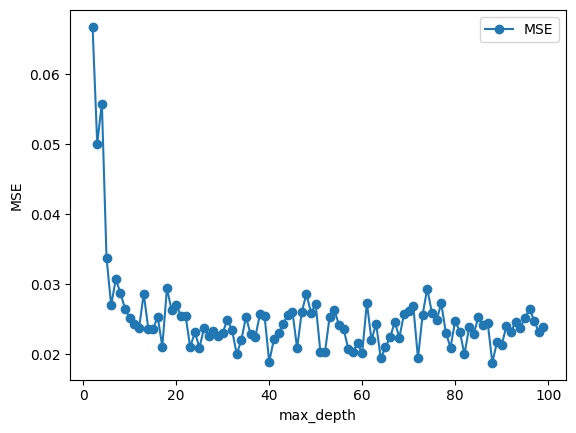

In [3]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def run_model(depth):
    X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)
    DT_model=DecisionTreeRegressor(min_samples_split=10, max_depth=depth)
    DT_model.fit(X_train,y_train)
    y_pred=DT_model.predict(X_test)
    MSE=mean_squared_error(y_pred,y_test)
    return MSE


MSESummary=[]
for depth in range(2,100,1):
    MSE=run_model(depth)
    MSESummary.append([depth,MSE])

MSESummaryDF=pd.DataFrame(MSESummary, columns=["max_depth","MSE"])
MSESummaryDF.plot(x="max_depth", y="MSE", kind='line', marker='o', ylabel='MSE')


In addition to limiting the "max_depth", we can also control overfitting using other parameters. This includes 
The start of MSE fluctuations is a sign of overfitting. Therefore, the best max_depth may be 6.

0.022876134178414994


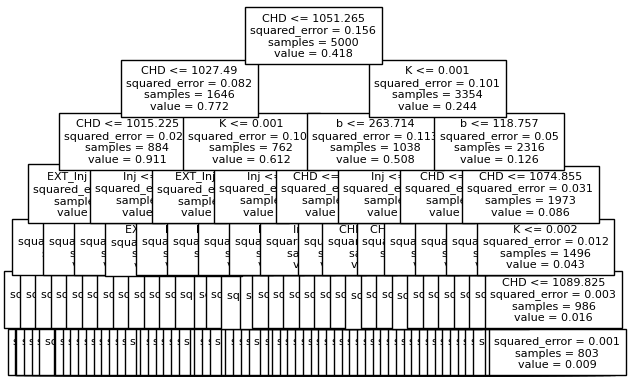

In [4]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)

BestModel=DecisionTreeRegressor(max_depth=6)
BestModel.fit(X,y)
y_pred=BestModel.predict(X_test)
best_DT_MSE=mean_squared_error(y_pred,y_test)
print(best_DT_MSE)

# also we can plot the best model
plot_tree(BestModel, filled=False, fontsize=8, feature_names=X.columns)
plt.show()

The "value" in each node is the average target values of samples in the node. The main weakness of DTs is that they are very sensitive to small variations in the training data. To address this weakness, we have to use Random Forest or other Ensemble methods. 

## Ensemble Learning
Ensemble learning means training a group of models/predictors and then making predictions using all of them. For classification problems, the predicted class can be the one which has the majority of votes from the ensemble models. For regression problem, like our problem, the predicted REN is the average of REN obtained from all Ensemble models. 

Ensemble methods work best when the predictors are as independent from one another as possible. 

### Ensemble of different algorithms 
This ensemble methods use predictors with very algorithm. For example, using DTs, SVD or linear regression in the ensemble and aggregate their results (using average of models as the prediction of the ensemble). A major benefit is that ddifferent models can be trained in parallel.

### Bagging
This method uses the same algorithm for all predictors but training them on different random subset of training set (rows) or subset of features (columns). Again, tarining models can be perform in parallel. Here, we explore the major hyperparameters of [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) API of scikit-learn. 
- estimator: this is the base algorithm for ensemble models. If unspecified, it defaults to DecisionTreeRegressor
-  n_estimators: The number predictors in the ensemble.
-  max_samples: The number of samples to draw from X to train each predictor. 
-  max_features: The number of features to draw from X to train each predictor
-  bootstrap: it is a boolen. If True (which is default), samples are drawn with replacement (which is calld bagging short for bootstrap agregating). If False, sampling without replacement (also called pasting) is performed meaning a sample (row) can only be selected from X once. 
-  n_jobs: The number of jobs to run in parallel for both fit and predict. using -1 means using all available processors.

In [14]:
from sklearn.ensemble import BaggingRegressor

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)

#build the base model of DT with max depth of 6 that was obtained as best max_depth above. 
DT_Model=DecisionTreeRegressor(max_depth=6)

# build an ensemble of 50 DT models. Allow using all available CPUs (n_jobs=-1)
Bag_model=BaggingRegressor(DT_Model, bootstrap=True,n_jobs=-1, n_estimators=50)

Bag_model.fit(X_train, y_train)
y_pred=Bag_model.predict(X_test)
bagging_MSE=mean_squared_error(y_pred,y_test)
print(bagging_MSE)

0.020505408779123206


We can see that using ensemble of 50 DTs, we are able to reduce MSE from 0.035 (from the best single DT model) to 0.019. 

### Random Forest (RF)
A Random Forest is essentially a specialized form of Bagging, as described above, with the key difference being that the base estimator/algorithm used in a Random Forest is always a decision tree. The scikit-learn [RF API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) has all hyperparameters of Decision tress plus all the hyperparameters of 'BaggingRegressor'. Below we build a RF model with similar paramaters to Bagging model we created earlier. 

In [6]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)
RF_Model=RandomForestRegressor(bootstrap=True,n_jobs=-1, n_estimators=50, max_depth=6)

RF_Model.fit(X_train, y_train)
y_pred=RF_Model.predict(X_test)
RF_MSE=mean_squared_error(y_pred,y_test)
print(RF_MSE)

0.019121491514514546


0.017

RF also allows measuring the relative importance of each feature. RF measures feature importance by calculating the average decrease in impurity (e.g., Gini impurity or entropy) that each feature causes when used for splitting across all decision trees in the forest. We can access feature importance scores after training a RF using the 'feature_importances_' attribute:

In [7]:
FeatureImpoDF=pd.DataFrame()
FeatureImpoDF["Feature"]=X.columns
FeatureImpoDF["Importance"]=RF_Model.feature_importances_
FeatureImpoDF.sort_values(by=["Importance"],inplace=True, ascending=False)
print(FeatureImpoDF)

   Feature  Importance
4      CHD    0.579131
0        K    0.218573
3        b    0.092264
1      Inj    0.066500
2      Por    0.024854
5  EXT_Inj    0.018423
6      DSP    0.000254


Results show that background groundwater grandient (CHD) and Hydraulic conductivity (K) are the most important features for REN prediction. 

### Gradient Boosting
Boosting refers to combining several weaker predictors into a strong predictor by training predictors sequantially, each trying to correct its predessor. Gradient boosting tries fitting a new predictor to the residual errors made by the previous predictor. 

In [13]:
# first model works on original dataset
Model1=DecisionTreeRegressor(max_depth=6)
Model1.fit(X_train, y_train)

#second model tries to predict residuals of the first model
Model2=DecisionTreeRegressor(max_depth=6)
M1_residuals=y_train-Model1.predict(X_train)
Model2.fit(X_train, M1_residuals)

#third model tries to predict residuals of second model
Model3=DecisionTreeRegressor(max_depth=6)
M2_residuals=M1_residuals-Model2.predict(X_train)
Model3.fit(X_train, M2_residuals)

#make prediction using all models in ensemble
y_pred=Model1.predict(X_test)+Model2.predict(X_test)+Model3.predict(X_test)
GB_MSE=mean_squared_error(y_pred,y_test)
print(GB_MSE)


0.022305141061297676


[Here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) is scikit API for regression gradient boosting. 

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)

GBModel=GradientBoostingRegressor(n_estimators=100, max_depth=6)
GBModel.fit(X_train, y_train)
y_pred=GBModel.predict(X_test)
print(mean_squared_error(y_pred,y_test))

0.0069586710811291655


0.006

In order to find the optimal number of models in our ensemble (paramater 'n_estimators'), we can use 'stages_predict()' method which returns y_pred for each sequential model.

Text(0.5, 0, 'model number')

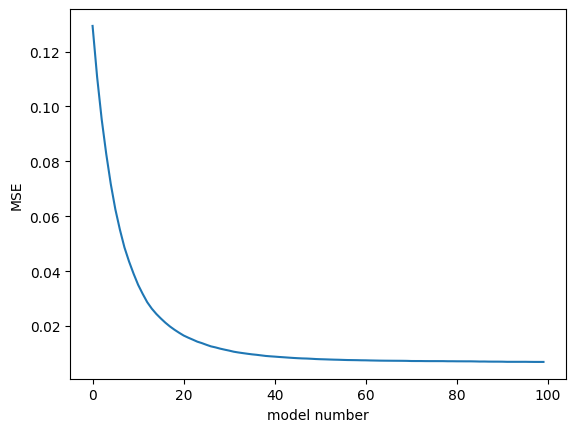

In [10]:
models_MSE=[mean_squared_error(y_test, y_pred) for y_pred in GBModel.staged_predict(X_test) ]
plt.plot(models_MSE)
plt.ylabel("MSE")
plt.xlabel("model number")

The plot shows that 20 can be a reasonable value for the number of moels in our Gradient Boosting ensemble. Insteam of scikit API, we can also use xgboost which provides an optimized implementation

In [12]:
import xgboost
XGModel=xgboost.XGBRegressor()
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.1)
XGModel.fit(X_train, y_train)
y_pred=XGModel.predict(X_test)
print(mean_squared_error(y_pred,y_test))

0.006552238635483285
